<a href="https://www.kaggle.com/code/edwardakalarrywelch/house-prices?scriptVersionId=90859751" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### This notebook is largely based on the instructional notebook created by Ryan Holbrook you can see [here](https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices).

### Imports

In [1]:
# Setup

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from category_encoders import CatBoostEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


## Data  ##

In [2]:
def load_data():
    
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
   
    # merge the splits so they can be processed better
    df = pd.concat([df_train, df_test])
    
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    
    return df_train, df_test


### Clean Data ###

In [3]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})

    # df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    df["GarageYrBlt"] = df["YearBuilt"]
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={"1stFlrSF": "FirstFlrSF","2ndFlrSF": "SecondFlrSF","3SsnPorch": "Threeseasonporch",}, inplace=True,)
    return df


### Define Nominal & Ordinal Variable

In [4]:

features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig",
                "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle",
                "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir",
                "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": [1,2,3,4,5,6,7,8,9,10],
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

def encode(df):
    
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))
    return df


### Missing Values ###

In [5]:
# here, we define a function for imputing missing values in dataframees containing numerical and categorical columns.
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(df[name].median())
    
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    
    return df

## Load Data ##

In [6]:
df_train, df_test = load_data()

In [7]:
# This code sets up a function for establishing a baseline score using the XGBRegressor model
def score_dataset(X, y, model=XGBRegressor()):
    
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log1p(y)
    score = cross_val_score(model, X, log_y, cv=5, scoring="neg_mean_squared_error")
    score = -1 * score.mean()
    score = np.sqrt(score)
    
    return score

In [8]:
# This code copies, trains, and get's a score for the dataset where X is a copy of df_train, and y is the target 'SalePrice'

X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.13852 RMSLE


### Mutual Information

In [9]:
# Here, we define a function, make_mi_scores to measure and plot mutual information.

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=3)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [10]:
# Here, the code calls the 'make_mi_scores' to call the function for scoring the Mutual Information for  
# features in our dataset.

X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     5.709380e-01
Neighborhood    5.264318e-01
GrLivArea       4.339960e-01
YearBuilt       4.082059e-01
GarageYrBlt     4.082059e-01
                    ...     
Street          3.633461e-04
Utilities       1.887379e-15
PoolArea        2.220446e-16
PoolQC          0.000000e+00
MoSold          0.000000e+00
Name: MI Scores, Length: 79, dtype: float64

In [11]:
# this code defines a function for dropping parameters (features) that score low on the mutual information score.

def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [12]:
# This code calls the drop_uninformative function to return a dataset that's scored again using the mi_scores

X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score = score_dataset(X, y)
print(score)

0.13651511370615788


## Create Features #

In [13]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [14]:

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    return X

# we define this function to help us determine the interactions between GrLivArea and 'BldgType'
def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X

# The counts function, defined here, gives us the counts of each feature listing is the X dataframe below.
def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[["WoodDeckSF","OpenPorchSF","EnclosedPorch","Threeseasonporch","ScreenPorch",]].gt(0.0).sum(axis=1)
    return X

#  Here, we define the break_down function which is used to break down the levels of the MSClass parameter.
def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X

# The group_transforms function defined below creates the 'MedNhbdArea' feature by grouping on 'Neighborhood'
# and 'GrLivArea' - and transforming by median.
def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X


## k-Means Clustering ##

In [15]:
cluster_features = ["LotArea","TotalBsmtSF","FirstFlrSF","SecondFlrSF","GrLivArea",]

# define the cluster_labels
def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new

# define the cluster_distance
def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
    return X_cd


### Principal Component Analysis ##

In [16]:

# Here, we apply_pca
def apply_pca(X, standardize=True):
   
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
     
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    
    return pca, X_pca, loadings

# here we plot variances, including explained variances and cumulative variances.
def plot_variance(pca, width=8, dpi=100):
    
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


In [17]:
# These functions implement PCA.

def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X

def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

pca_features = ["GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea",]

### Correlation of Numerical Features

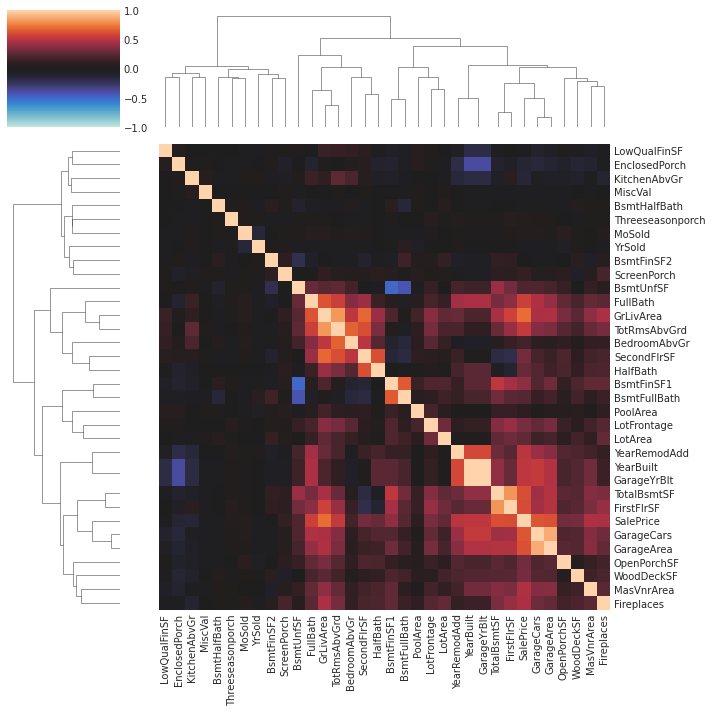

In [18]:
# the corrplot function below creates a correlation matrix of the numerical features in the dataframe.  It's more of 
# an data exploration analysis function

def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(df.corr(method),vmin=-1.0,vmax=1.0,cmap="icefire",method="complete",annot=annot,**kwargs,)

corrplot(df_train, annot=None)

In [19]:
# This code defines the indicate_outliers function that transforms the dataframe based on houses in the 'Edwards'
# 'Edward's' neighborhood having a 'SaleCondition' of 'Partial'

def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = ((df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial"))
    return X_new


## Target Encoding ##

In [20]:
# This class creates a CrossFoldEncoder.  It's purpose it to enable the use of 'tareget encoding' without having
# to use 'held-out' encoding data.

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)
    
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        
        return X_encoded

    # To transform the test data, average the encodings learned from each fold.
    
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        
        return X_encoded


## Final Feature Set ##

In [21]:
# Here, we define a function that creates_features.  These functions are defined seperately so we can experiment with
# more combinations of features, etc. without having the code entangled.

def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features, we'll recreate the splits.
   
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    X = X.join(group_transforms(X))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    X = X.join(indicate_outliers(X))
    
    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X

df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score = score_dataset(X_train, y_train)
print(score)

0.1404790236753278


In [22]:
df_train.shape

(1460, 80)

In [23]:
df_test.shape

(1459, 80)

## XGBoost Model Training

In [24]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    # objective='reg:squarederror',
    # tree_method='gbtree',
    n_jobs = -1,
    max_depth=3,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.004317178406870844,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=4692,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.24179647848331182,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample= 0.6965948769950945,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.003969806491630096,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=0.001766947001110234,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=5,   # set > 1 for boosted random forests
    random_state=9,
)


xgb = XGBRegressor(**xgb_params)
score = score_dataset(X_train, y_train, xgb)

print(score)

0.11498195526396646


## Hyperparameter Tune XGBoost with Optuna #

In [25]:
# This code block uses optuna hyper-parameter tuning to iprove the XGBRegressor settings.

# import optuna
# import sklearn.metrics

# def objective(trial):
#     xgb_params = dict(
#         objective='reg:squarederror',
#         n_jobs = -1,
#         tree_method='gbtree',
#         max_depth=trial.suggest_int("max_depth", 1, 3),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, .1),
#         n_estimators=trial.suggest_int("n_estimators", 500, 8000),
#         min_child_weight=trial.suggest_int("min_child_weight", 1,3),
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1.0),
#         subsample=trial.suggest_float("subsample", 0.2, 1.0),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#         random_state=7,
#     )
#     xgb = XGBRegressor(**xgb_params)
#     score=score_dataset(X_train,y_train,xgb)
    
#     return score

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=500)
# # xgb_params = study.best_params

### Submission

In [26]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)

xgb.fit(X_train, np.log1p(y))
predictions = np.expm1(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
